In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from zoneinfo import ZoneInfo 

# Assuming you have loaded the first dataset and its reference data
sensor_id = "Fresno"
date_file = r"C:\Documents\Senior Year - College\Research\DataPullCode\PMDataCals\present_dates.xlsx"
sensor_file_1 = rf"C:\\Documents\\Senior Year - College\\Research\\DataPullCode\\PMDataCals\\VOZ_Box_{sensor_id}_mod.csv"
reference_file_1 = r"C:\\Documents\\Senior Year - College\\Research\\CalibrationCodes\\Torrias2025Calibration\\PM25HR_PICKDATA_2023-12-31-Fresno.csv"
reference_file_2 = r"C:\\Documents\\Senior Year - College\\Research\\CalibrationCodes\\Torrias2025Calibration\\PM25HR_PICKDATA_2023-12-31-Fresno.csv" #Uncomment for any monitor with no FEM nearby
#reference_file_2 = r"C:\\Documents\\Senior Year - College\\Research\\CalibrationCodes\\Torrias2025Calibration\\PM25HR_PICKDATA_2023-10-31-Porterville.csv" #Uncomment for Terra Bella
#reference_file_2 = r"C:\\Documents\\Senior Year - College\\Research\\CalibrationCodes\\Torrias2025Calibration\\PM25HR_PICKDATA_2023-12-31-Tranquility.csv" # Uncomment for Tranquility

# Read date_file to collect info about pre and post calibration and deployment dates
dates = pd.read_excel(date_file, sheet_name=1)
row = dates.loc[dates['sensor_id'] == sensor_id].squeeze()
date_columns = [col for col in dates.columns if col not in ['sensor_id', 'PreNumDays', 'PostNumDays', 'WithFEM']]
row[date_columns] = pd.to_datetime(row[date_columns])

# Assign Pre and Post-calibration dates
precal_start = row['newprestart']
precal_end   = row['newpreend'] - pd.Timedelta(days=1)
postcal_start = row['newpoststart']
postcal_end   = row['newpostend']

#Assign dates for trial period
trial1_start = row['Trial1Start']
trial1_end = row['Trial1End']
trial2_start = row['Trial2Start']
trial2_end = row['Trial2End']

reference_data_deploysite = pd.read_csv(reference_file_2)
reference_data_deploysite['date_time'] = pd.to_datetime(reference_data_deploysite['date'] + " " + reference_data_deploysite['time'])
reference_data_deploysite['date_time'] = reference_data_deploysite['date_time'] + pd.Timedelta(hours=8)
reference_data_deploysite.set_index('date_time', inplace=True)
reference_data_deploysite['reference'] = reference_data_deploysite['value']
reference_data_deploysite.index = pd.to_datetime(reference_data_deploysite.index, utc=True)

PM25_data_1 = pd.read_csv(sensor_file_1)
PM25_data_1['date_time'] = pd.to_datetime(PM25_data_1['date_time'])
PM25_data_1.set_index('date_time', inplace=True)
PM25_data_resampled_1 = (
    PM25_data_1.resample('1h', label='right', closed='right')
    .mean()
    .shift(freq='-30min')
)
PM25_data_resampled_1 = PM25_data_resampled_1[(PM25_data_resampled_1.index >= precal_start) & (PM25_data_resampled_1.index <= precal_end)]
PM25_data_resampled_1.index = pd.to_datetime(PM25_data_resampled_1.index, utc=True)

# Load reference data for the first dataset
## Replace file directory with directory for FEM data
reference_data = pd.read_csv(reference_file_1)
reference_data['date_time'] = pd.to_datetime(reference_data['date'] + " " + reference_data['time'])
reference_data['date_time'] = reference_data['date_time'] + pd.Timedelta(hours=8)
reference_data.set_index('date_time', inplace=True)
reference_data['reference'] = reference_data['value'] 
reference_data.index = pd.to_datetime(reference_data.index, utc=True)

# Merge the datasets for the first dataset
merged_data_1 = PM25_data_resampled_1.join(reference_data, how='inner')

# Assuming you have loaded the second dataset and its reference data
sensor_file_2 = sensor_file_1

PM25_data_2 = pd.read_csv(sensor_file_2)
PM25_data_2['date_time'] = pd.to_datetime(PM25_data_2['date_time'])
PM25_data_2.set_index('date_time', inplace=True)
PM25_data_resampled_2 = (
    PM25_data_2.resample('1h', label='right', closed='right')
    .mean()
    .shift(freq='-30min')
)
PM25_data_resampled_2 = PM25_data_resampled_2[(PM25_data_resampled_2.index >= postcal_start) & (PM25_data_resampled_2.index <= postcal_end)]
PM25_data_resampled_2.index = pd.to_datetime(PM25_data_resampled_2.index, utc=True)

# Merge the datasets for the second dataset
if sensor_id == "Tranquility":
    merged_data_2 = PM25_data_resampled_2.join(reference_data_deploysite, how='inner') # Use for Tranquility site
else:
    merged_data_2 = PM25_data_resampled_2.join(reference_data, how='inner') # Use for all sites except Tranquility
merged_data_combined = pd.concat([merged_data_1, merged_data_2
                                  ])

#Convert all data to Pacific Time for later use
merged_data_combined.index = pd.to_datetime(merged_data_combined.index, utc=True)
merged_data_combined.index = merged_data_combined.index.tz_convert('US/Pacific')
merged_data_combined.index = merged_data_combined.index.tz_localize(None)

reference_data.index = reference_data.index.tz_convert('US/Pacific')
reference_data.index = reference_data.index.tz_localize(None)

reference_data_deploysite.index = reference_data_deploysite.index.tz_convert('US/Pacific')
reference_data_deploysite.index = reference_data_deploysite.index.tz_localize(None)

# print(merged_data_combined.head())
merged_data_combined['day_counter'] = (merged_data_combined.index - merged_data_combined.index[0]).days+1

# Add 'week' columns
merged_data_combined['month'] = merged_data_combined.index.month
merged_data_combined['week'] = merged_data_combined.index.isocalendar().week

# Function to eliminate outliers using Z-score
def eliminate_outliers(data, column, z_threshold=3):
    z_scores = np.abs((data[column] - data[column].mean()) / data[column].std())
    filtered_data = data[(z_scores < z_threshold)]
    return filtered_data

# Define the Z-score threshold for outlier removal
z_threshold = 1

# Apply outlier elimination to the 'o3' column in the merged data
merged_data_combined = eliminate_outliers(merged_data_combined, 'm_PM25_b', z_threshold)

print(merged_data_combined.head())

C:\Users\tlc72\AppData\Local\Temp\ipykernel_72088\3303180304.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  reference_data_deploysite['date_time'] = pd.to_datetime(reference_data_deploysite['date'] + " " + reference_data_deploysite['time'])
C:\Users\tlc72\AppData\Local\Temp\ipykernel_72088\3303180304.py:55: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  reference_data['date_time'] = pd.to_datetime(reference_data['date'] + " " + reference_data['time'])


                     Unnamed: 0      unixtime  m_PM1_CF1  m_PM1_ATM   m_PM1_b  \
date_time                                                                       
2023-06-07 15:30:00   47.666667  1.686177e+09  12.741667  12.741667  7.260000   
2023-06-07 16:30:00  116.666667  1.686181e+09  15.323333  15.323333  8.126667   
2023-06-07 17:30:00   60.666667  1.686184e+09  16.538333  16.533333  8.323333   
2023-06-07 18:30:00  162.000000  1.686188e+09  14.545000  14.545000  7.456667   
2023-06-07 19:30:00  262.000000  1.686192e+09  12.221667  12.221667  6.736667   

                     m_PM25_CF1  m_PM25_ATM  m_PM25_b   m_PM4_b  m_PM10_CF1  \
date_time                                                                     
2023-06-07 15:30:00   17.955000   17.955000  7.615000  7.615000   18.936667   
2023-06-07 16:30:00   21.698333   21.698333  8.523333  8.523333   22.658333   
2023-06-07 17:30:00   22.936667   22.936667  8.730000  8.730000   23.838333   
2023-06-07 18:30:00   20.083333   20.

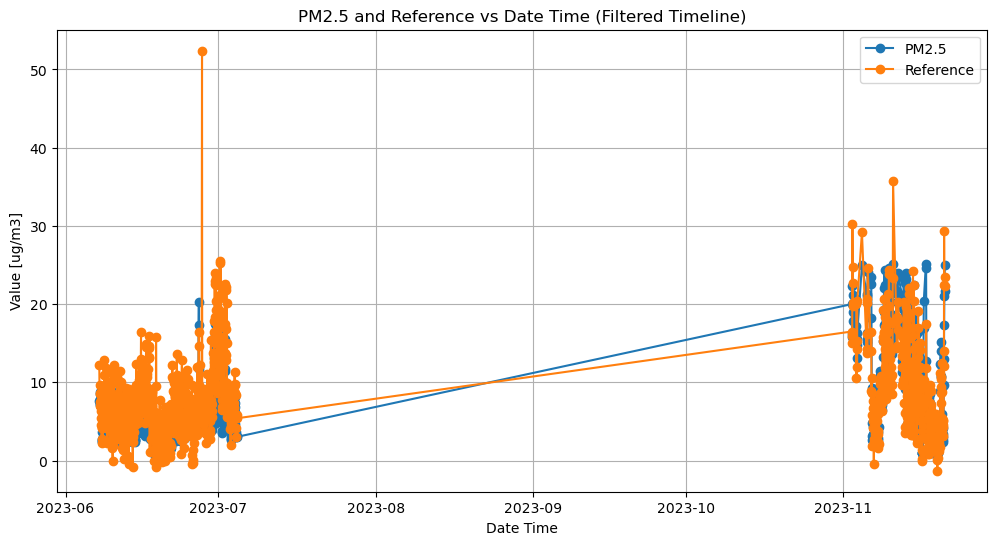

In [13]:
# Define the start and end dates for the desired timeline
start_date_filter = pd.to_datetime("2023-06-07")
end_date_filter = pd.to_datetime("2023-11-21")

# Apply the date range filter to the merged data
filtered_data = merged_data_combined[(merged_data_combined.index >= start_date_filter) & (merged_data_combined.index <= end_date_filter)]

# Line plot for 'o3' and 'reference' columns against 'date_time' within the specified timeline
plt.figure(figsize=(12, 6))

# Plot 'o3' column
plt.plot(filtered_data.index, filtered_data['m_PM25_b'], label='PM2.5', marker='o')

# Plot 'reference' column
plt.plot(filtered_data.index, filtered_data['reference'], label='Reference', marker='o')

# Customize the plot
plt.title('PM2.5 and Reference vs Date Time (Filtered Timeline)')
plt.xlabel('Date Time')
plt.ylabel('Value [ug/m3]')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
from sklearn.linear_model import ElasticNet
import pandas as pd
import numpy as np

# Individual unit remake of Clarity's calibration

def calc_dew_point(T, rh):
    #Calculate temp minus dew
    a = 17.62
    b = 243.12
    gammaTrh = (a*T)/(b+T) + np.log(rh / 100.0)
    Td = (b * gammaTrh) / (a - gammaTrh)
    return Td

merged_data_combined['dew_point'] = calc_dew_point(merged_data_combined['tempC_sen5x'], merged_data_combined['rh_sen5x'])
merged_data_combined['temp_minus_dew_point'] = merged_data_combined['tempC_sen5x'] - merged_data_combined['dew_point']
merged_data_combined['pm_rh_interaction'] = merged_data_combined['m_PM25_b'] * merged_data_combined['rh_sen5x']

def multivariate_calibration_selected_columns(reference, data, required_columns):
    if len(reference) != len(data):
        raise ValueError("Reference and data must have the same length.")

    data_selected_columns = data[required_columns]

    mask = np.isfinite(data_selected_columns).all(axis=1) & np.isfinite(reference)
    valid_samples = mask.sum()

    if valid_samples == 0:
        raise ValueError("No valid samples available for calibration. Check your cleaning steps.")

    print("Number of valid samples after cleaning:", valid_samples)

    X_cleaned = data_selected_columns[mask]
    y_cleaned = reference[mask]

    # Create and fit the ElasticNet regression model
    model = ElasticNet(max_iter=50000, alpha=0.3, l1_ratio=0.1)  # Adjust alpha and l1_ratio as needed
    model.fit(X_cleaned, y_cleaned)

    # Get the coefficients (slopes) and intercept
    slopes = model.coef_
    intercept = model.intercept_

    print("Coefficients (slopes):", slopes)
    print("Intercept (b0):", intercept)

    # Calibrate the data using the regression model
    calibrated_data = model.predict(data_selected_columns)

                 # Create a new DataFrame with calibrated values
    # Combine slopes and intercept
    params = list(slopes) + [intercept]
    labels = required_columns + ['intercept']

    # Transpose: one row, each column is a parameter
    params_df = pd.DataFrame([params], columns=labels)

    # Save to Excel
    params_df.to_excel(rf"C:\Documents\Senior Year - College\Research\CalibrationCodes\Torrias2025Calibration\PMCalibrationsSensirion\{sensor_id}ClarityRemake.xlsx", index=False)

    return calibrated_data, slopes, intercept

# Example usage
if __name__ == "__main__":
    uncalibrated_data = merged_data_combined
    reference_data_elastic = merged_data_combined['reference']
    required_columns = ['rh_sen5x','m_PM25_b','m_PM1_b','temp_minus_dew_point','pm_rh_interaction']

    try:
        calibrated_data = multivariate_calibration_selected_columns(reference_data_elastic, uncalibrated_data, required_columns)
        print("Calibrated data:", calibrated_data)
    except ValueError as e:
        print("Error:", e)


Number of valid samples after cleaning: 1074
Coefficients (slopes): [-0.00835999  0.34525539  0.35297471  0.10091754  0.00080019]
Intercept (b0): 2.012732831306769
Calibrated data: (array([ 8.373367  ,  8.98261747,  9.29810831, ..., 14.49511687,
       13.14505214, 17.02714941]), array([-0.00835999,  0.34525539,  0.35297471,  0.10091754,  0.00080019]), 2.012732831306769)


In [15]:
#elasticnet regression with 2 variables
from sklearn.linear_model import ElasticNet
import pandas as pd
import numpy as np

def multivariate_calibration_selected_columns(reference, data, required_columns):
    if len(reference) != len(data):
        raise ValueError("Reference and data must have the same length.")

    data_selected_columns = data[required_columns]

    mask = np.isfinite(data_selected_columns).all(axis=1) & np.isfinite(reference)
    valid_samples = mask.sum()

    if valid_samples == 0:
        raise ValueError("No valid samples available for calibration. Check your cleaning steps.")

    print("Number of valid samples after cleaning:", valid_samples)

    X_cleaned = data_selected_columns[mask]
    y_cleaned = reference[mask]

    # Create and fit the ElasticNet regression model
    model = ElasticNet(alpha=0.3, l1_ratio=0.1)  # Adjust alpha and l1_ratio as needed
    model.fit(X_cleaned, y_cleaned)

    # Get the coefficients (slopes) and intercept
    slopes = model.coef_
    intercept = model.intercept_

    print("Coefficients (slopes):", slopes)
    print("Intercept (b0):", intercept)

    # Calibrate the data using the regression model
    calibrated_data = model.predict(data_selected_columns)

                 # Create a new DataFrame with calibrated values
    # Combine slopes and intercept
    params = list(slopes) + [intercept]
    labels = required_columns + ['intercept']

    # Transpose: one row, each column is a parameter
    params_df = pd.DataFrame([params], columns=labels)

    # Save to Excel
    params_df.to_excel(rf"C:\Documents\Senior Year - College\Research\CalibrationCodes\Torrias2025Calibration\PMCalibrationsSensirion\{sensor_id}2Vars.xlsx", index=False)

    return calibrated_data, slopes, intercept

# Example usage
if __name__ == "__main__":
    uncalibrated_data = merged_data_combined
    reference_data_elastic = merged_data_combined['reference']
    required_columns = ['rh_sen5x',
                        'm_PM25_b']

    try:
        calibrated_data = multivariate_calibration_selected_columns(reference_data_elastic, uncalibrated_data, required_columns)
        print("Calibrated data:", calibrated_data)
    except ValueError as e:
        print("Error:", e)



Number of valid samples after cleaning: 1074
Coefficients (slopes): [-0.04041866  0.71629839]
Intercept (b0): 4.901903881958841
Calibrated data: (array([ 8.51005696,  9.11488685,  9.42998565, ..., 14.70176722,
       13.30771618, 17.14631069]), array([-0.04041866,  0.71629839]), 4.901903881958841)


In [16]:
import pandas as pd

# Load the Excel file containing model parameters
ClarityRemake_df = pd.read_excel(rf"C:\Documents\Senior Year - College\Research\CalibrationCodes\Torrias2025Calibration\PMCalibrationsSensirion\{sensor_id}ClarityRemake.xlsx")
BasicCalibration_df = pd.read_excel(rf"C:\Documents\Senior Year - College\Research\CalibrationCodes\Torrias2025Calibration\PMCalibrationsSensirion\{sensor_id}2Vars.xlsx")

calibrated_data = pd.read_csv(sensor_file_1)[['date_time','m_PM1_b','m_PM25_CF1','m_PM25_ATM','m_PM25_b','m_PM4_b','m_PM10_CF1','m_PM10_ATM','m_PM10_b','temp_C','tempC_sen5x','rh','rh_sen5x','lat','lon']]
calibrated_data['date_time'] = pd.to_datetime(calibrated_data['date_time'])
calibrated_data['date_time'] = calibrated_data['date_time']
calibrated_data.set_index('date_time', inplace=True)
# Remove outliers
calibrated_data = calibrated_data[calibrated_data['m_PM25_b'] >= 0]  # Assuming ozone values below 0 are outliers
calibrated_data = calibrated_data[calibrated_data['m_PM25_b'] <= 100]  # Assuming ozone values above 100 are outliers
# Resample
calibrated_data= (
    calibrated_data.resample('1h', label='right', closed='right')
    .mean()
    .shift(freq='-30min')
)

calibrated_data.index = pd.to_datetime(calibrated_data.index, utc=True)
calibrated_data.index = calibrated_data.index.tz_convert('US/Pacific')
calibrated_data.index = calibrated_data.index.tz_localize(None)

calibrated_data['dew_point'] = calc_dew_point(calibrated_data['tempC_sen5x'], calibrated_data['rh_sen5x'])
calibrated_data['temp_minus_dew_point'] = calibrated_data['tempC_sen5x'] - calibrated_data['dew_point']
calibrated_data['pm_rh_interaction'] = calibrated_data['m_PM25_b'] * calibrated_data['rh_sen5x']

# Add 'month' columns
calibrated_data['week'] = calibrated_data.index.isocalendar().week
calibrated_data['month'] = calibrated_data.index.month


# Function to calibrate PM data using given calibration parameters for model 1
def calibrate_PM_model1(rh, pm25, pm1, tminusdew, pmrh,
                           calibration_params):
    return (rh * calibration_params[0]) + (pm25 * calibration_params[1]) +(pm1 * calibration_params[2]) + (tminusdew * calibration_params[3]) + (pmrh * calibration_params[4]) + calibration_params[5]

# Function to calibrate PM data using given calibration parameters for model 2
def calibrate_PM_model2(rh, m_PM25_b, calibration_params):
    return  (rh * calibration_params[0]) + (m_PM25_b * calibration_params[1]) + calibration_params[2]

# Calibration parameters for model 1 for one sensor
calibration_params_model1 = ClarityRemake_df.iloc[0].tolist() # Parameters for Model 1

# Calibration parameters for model 2 for one sensor
calibration_params_model2 = BasicCalibration_df.iloc[0].tolist() # Parameters for Model 2

# Apply calibration model 1
calibrated_data['PM_calibrated_ClarityRemake'] = calibrate_PM_model1(calibrated_data['rh_sen5x'], calibrated_data['m_PM25_b'], calibrated_data['m_PM1_b'], calibrated_data['temp_minus_dew_point'], calibrated_data['pm_rh_interaction'], calibration_params_model1)

# Apply calibration model 2
calibrated_data['PM_calibrated_Basic'] = calibrate_PM_model2(calibrated_data['rh_sen5x'], calibrated_data['m_PM25_b'], calibration_params_model2)

# Save the calibrated data to the same CSV file in two different columns
file = rf"C:\\Documents\\Senior Year - College\\Research\\CalibrationCodes\\Torrias2025Calibration\\voz-data-analysis\\reference_files\\2023SensirionDataCalibrated\\{sensor_id}.csv"
output_file = file.replace(".csv", "_calibrated.csv")
calibrated_data.to_csv(output_file, index=True)

print(f"Calibration complete. File saved as {output_file}.")


Calibration complete. File saved as C:\\Documents\\Senior Year - College\\Research\\CalibrationCodes\\Torrias2025Calibration\\voz-data-analysis\\reference_files\\2023SensirionDataCalibrated\\Fresno_calibrated.csv.


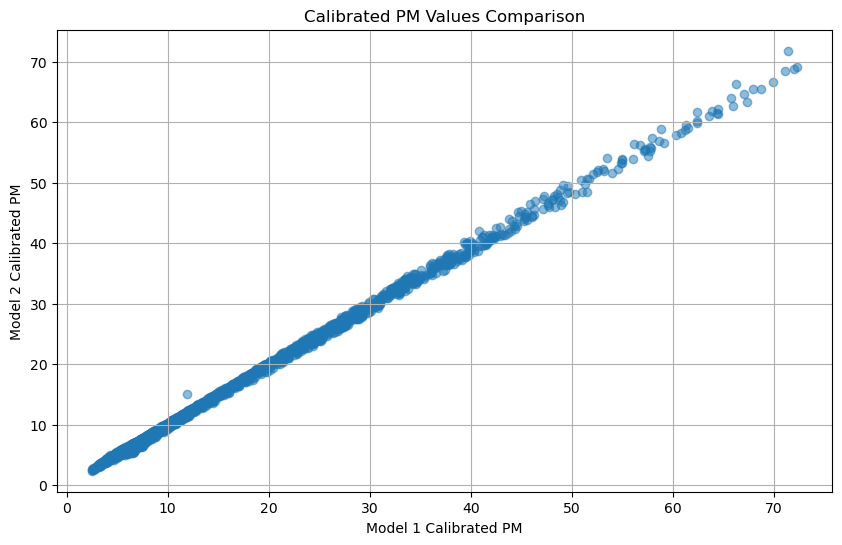

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

calibrated_file = rf"C:\\Documents\\Senior Year - College\\Research\\CalibrationCodes\\Torrias2025Calibration\\voz-data-analysis\\reference_files\\2023SensirionDataCalibrated\\{sensor_id}_calibrated.csv"

# Load the calibrated data
calibrated_data = pd.read_csv(calibrated_file, parse_dates=['date_time'])
calibrated_data['date_time'] = pd.to_datetime(calibrated_data['date_time'])
calibrated_data.set_index('date_time', inplace=True)
calibrated_data.index = pd.to_datetime(calibrated_data.index)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(calibrated_data['PM_calibrated_ClarityRemake'], calibrated_data['PM_calibrated_Basic'], alpha=0.5)
plt.title('Calibrated PM Values Comparison')
plt.xlabel('Model 1 Calibrated PM')
plt.ylabel('Model 2 Calibrated PM')
plt.grid(True)
# plt.show()


In [18]:
import numpy as np

#Clarity Clarity Calibration Model released on April 23, 2025
#Uses variables: rh, temp minus dew (magnus formula), pm rh interaction, pm2.5, pm10, pm1

output_file = calibrated_file

calibrated_data['omega'] = (100 - calibrated_data['m_PM25_b'])/(200)

#Low value includes all coefficients listed above
ClarityLowValParams_df = pd.read_excel(rf"C:\Documents\Senior Year - College\Research\CalibrationCodes\Torrias2025Calibration\PMCalibrationsPlantower\ClarityLowValVars.xlsx")
#High value includes only PM2.5
ClarityHighValParams_df = pd.read_excel(rf"C:\Documents\Senior Year - College\Research\CalibrationCodes\Torrias2025Calibration\PMCalibrationsPlantower\ClarityHighValVars.xlsx")

#Transition includes both upper and lower calibrated values along with omega w

# Function to calibrate PM data using given calibration parameters for PM values < 100
def calibrate_PM_Claritylow(rh, m_PM25_b, m_PM10_b, m_PM1_b, temp_minus_dew_point, pm_rh_interaction,
                           calibration_params):
    return (rh * calibration_params[0]) + (m_PM25_b * calibration_params[1]) +(m_PM10_b * calibration_params[2]) + (m_PM1_b * calibration_params[3]) + \
        (temp_minus_dew_point * calibration_params[4]) +(pm_rh_interaction * calibration_params[5]) + calibration_params[6]

# Function to calibrate PM data using given calibration parameters for PM values >= 100 and <= 300
def calibrate_PM_Claritytransition(omega, PMlow, PMhigh):
    return (omega * PMlow) + ((1 - omega) * PMhigh)

# Function to calibrate PM data using given calibration parameters for PM Values > 300
def calibrate_PM_Clarityhigh(m_PM25_b, calibration_params):
    return (m_PM25_b * calibration_params[0])

# Call to decide which calibration method will be used and apply it
def calibrate_PM_Clarity(row):
    pm = row['m_PM25_b']
    
    if pm < 100:
        return calibrate_PM_Claritylow(
            row['rh_sen5x'],
            row['m_PM25_b'],
            row['m_PM10_b'],
            row['m_PM1_b'],
            row['temp_minus_dew_point'],
            row['pm_rh_interaction'],
            calibration_params_Claritylow
        )
    elif 100 <= pm <= 300:
        pm_low = calibrate_PM_Claritylow(
            row['rh_sen5x'],
            row['m_PM25_b'],
            row['m_PM10_b'],
            row['m_PM1_b'],
            row['temp_minus_dew_point'],
            row['pm_rh_interaction'],
            calibration_params_Claritylow
        )
        pm_high = calibrate_PM_Clarityhigh(
            row['m_PM25_b'],
            calibration_params_Clarityhigh
        )
        return calibrate_PM_Claritytransition(
            row['omega'],
            pm_low,
            pm_high
        )
    else:  # pm > 300
        return calibrate_PM_Clarityhigh(
            row['m_PM25_b'],
            calibration_params_Clarityhigh
        )

# Calibration parameters for model 1 for one sensor
calibration_params_Claritylow = ClarityLowValParams_df.iloc[0].tolist() # Parameters for low PM

# Calibration parameters for model 2 for one sensor
calibration_params_Clarityhigh = ClarityHighValParams_df.iloc[0].tolist() # Parameters for high PM

# Calibrate
calibrated_data['PM_calibrated_Clarity'] = calibrated_data.apply(calibrate_PM_Clarity, axis=1)

# Save the calibrated data to the same CSV file in two different columns
calibrated_data.to_csv(output_file, index=True)





In [19]:
# EPA 2021 Correction

output_file = rf"C:\\Documents\\Senior Year - College\\Research\\DataPullCode\\PMDataCals\\VOZ_Box_{sensor_id}_mod_calibrated.csv"

EPA2021Params_df = pd.read_excel(rf"C:\Documents\Senior Year - College\Research\CalibrationCodes\Torrias2025Calibration\PMCalibrationsPlantower\EPA2021Vars.xlsx")

def calibrate_PM_EPA2021(PM, rh, calibration_params):
    return (PM * calibration_params[0]) + (rh * calibration_params[1]) + calibration_params[2]

calibration_params_EPA2021 = EPA2021Params_df.iloc[0].tolist() # Parameters for 2021 Calibration

# Calibrate
calibrated_data['PM_calibrated_EPA_Barkjohn'] = calibrate_PM_EPA2021(calibrated_data['m_PM25_b'], calibrated_data['rh_sen5x'], calibration_params_EPA2021)

# Save the calibrated data to the same CSV file in two different columns
calibrated_data.to_csv(output_file, index=True)





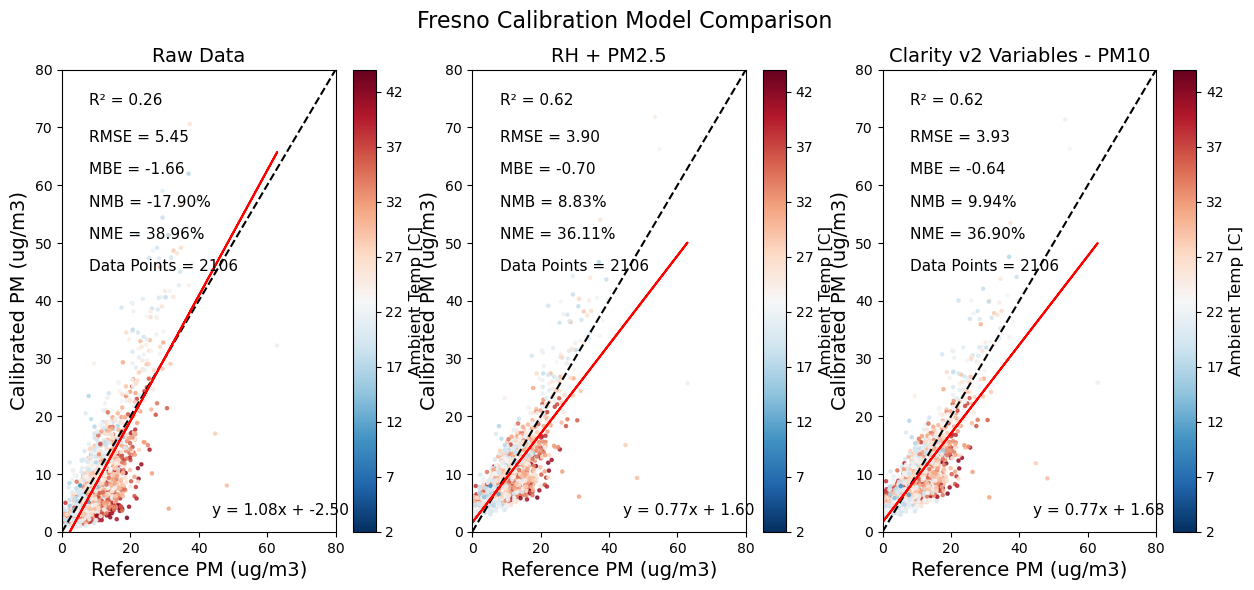

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, root_mean_squared_error
from matplotlib.colors import Normalize, ListedColormap
from matplotlib.cm import ScalarMappable
import calendar
import numpy as np
import math
from scipy import stats

# For early summer
precal_data = calibrated_data.loc[precal_start:precal_end]
precal_merged = precal_data.join(reference_data['value'], how='inner')
precal_merged.rename(columns={'value': 'reference'}, inplace=True)

# For fall
postcal_data = calibrated_data.loc[postcal_start:postcal_end]
if sensor_id == "Tranquility":
    postcal_merged = postcal_data.join(reference_data_deploysite['value'], how='inner')
else:
    postcal_merged = postcal_data.join(reference_data['value'], how='inner')
postcal_merged.rename(columns={'value': 'reference'}, inplace=True)

trial1_data = calibrated_data.loc[trial1_start:trial1_end]
trial1_merged = trial1_data.join(reference_data_deploysite['reference'], how='inner')
trial1_merged.rename(columns={'reference': 'reference'}, inplace=True)

trial2_data = calibrated_data.loc[trial2_start:trial2_end]
trial2_merged = trial2_data.join(reference_data_deploysite['reference'], how='inner')
trial2_merged.rename(columns={'reference': 'reference'}, inplace=True)

merged_data_yearround = pd.concat([trial1_merged, trial2_merged])
#merged_data_yearround = pd.concat([precal_merged, postcal_merged])

# Drop rows with missing values in the columns of interest
merged_data_yearround.dropna(subset=['reference', 'PM_calibrated_Basic', 'PM_calibrated_ClarityRemake', 'm_PM25_b', 'PM_calibrated_EPA_Barkjohn', 'PM_calibrated_Clarity'], inplace=True)

#Function to add stuff to plots
def add_to_plots(i, model, name, axs):
    # If axs is a 2D array (grid)
    if isinstance(axs, np.ndarray):
        ax = axs[i]
    else:
        ax = axs  # single subplot case

    x = merged_data_yearround['reference']
    y = merged_data_yearround[model]

    sc = ax.scatter(
        x,
        y,
        c=merged_data_yearround['temp_C'],
        cmap='RdBu_r',
        norm=temp_norm,
        alpha=0.8,
        s=5
    )

    # Add 1:1 line
    ax.plot([0, 100], [0, 100], c='black', linestyle='--', label='1:1')

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    y_fit = slope * x + intercept

    ax.plot(x, y_fit, c = 'red', label = 'Best fit')

    # Metrics
    r2, rmse, mbe, nmb, nme = calculate_metrics(merged_data_yearround['reference'], merged_data_yearround[model])
    ax.text(0.1, 0.95, f'R\u00b2 = {r2:.2f}', transform=ax.transAxes, fontsize=11, verticalalignment='top')
    ax.text(0.1, 0.87, f'RMSE = {rmse:.2f}', transform=ax.transAxes, fontsize=11, verticalalignment='top')
    ax.text(0.1, 0.80, f'MBE = {mbe:.2f}', transform=ax.transAxes, fontsize=11, verticalalignment='top')
    ax.text(0.1, 0.73, f'NMB = {nmb:.2%}', transform=ax.transAxes, fontsize=11, verticalalignment='top')
    ax.text(0.1, 0.66, f'NME = {nme:.2%}', transform=ax.transAxes, fontsize=11, verticalalignment='top')
    ax.text(0.1, 0.59, f'Data Points = {len(merged_data_yearround)}', transform=ax.transAxes, fontsize=11, verticalalignment='top')
    ax.text(0.55, 0.03, f'y = {slope:.2f}x + {intercept:.2f}',transform=ax.transAxes, fontsize=11, verticalalignment='bottom')

    # Colorbar
    sm = ScalarMappable(cmap='RdBu_r', norm=temp_norm)
    sm.set_array([])
    ticks = np.arange(vmin, vmax + 1, 5)
    cbar = plt.colorbar(sm, ax=ax, ticks=ticks)
    cbar.set_ticklabels([str(t) for t in ticks])
    cbar.set_label('Ambient Temp [C]', fontsize=12)

    # Titles & labels
    ax.set_title(f'{name}', fontsize=14)
    ax.set_xlabel('Reference PM (ug/m3)', fontsize=14)
    ax.set_ylabel(f'Calibrated PM (ug/m3)', fontsize=14)

    ax.set_xlim(0, 80)
    ax.set_ylim(0, 80)

# Function to calculate metrics
def calculate_metrics(observed, predicted):
    r2 = r2_score(observed, predicted)
    rmse = root_mean_squared_error(observed, predicted)
    mbe = (predicted - observed).mean()
    
    # Calculate percentage errors, handling division by zero
    nmb = np.nanmean(np.divide(predicted - observed, observed, out=np.zeros_like(predicted - observed), where=observed!=0))
    nme = np.nanmean(np.divide(abs(predicted - observed), observed, out=np.zeros_like(abs(predicted - observed)), where=observed!=0))
    
    return r2, rmse, mbe, nmb, nme

# Set up 2x2 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(15,6))
fig.suptitle(f"{sensor_id} Calibration Model Comparison\n", fontsize=16)
fig.subplots_adjust(hspace=0.3)  # increase vertical space between rows

# Get unique months from the datetime index
# months_present = merged_data_yearround.index.month.unique()

# # Determine the min and max months in the data
# vmin = months_present.min()
# vmax=12
# month_norm = Normalize(vmin=vmin, vmax=vmax)

#Determine min and max temps in data
vmin = math.floor(calibrated_data['temp_C'].min())
vmax = math.ceil(calibrated_data['temp_C'].max())
temp_norm = Normalize(vmin=vmin, vmax=vmax)

add_to_plots(2,'PM_calibrated_ClarityRemake', 'Clarity v2 Variables - PM10', axs)
add_to_plots(1,'PM_calibrated_Basic', 'RH + PM2.5', axs)
add_to_plots(0,'m_PM25_b', 'Raw Data', axs)

plt.savefig(rf"C:\Documents\Senior Year - College\Research\CalibrationCodes\Torrias2025Calibration\PMCalibrationsSensirion\{sensor_id}CalibrationStatswEPA.jpg", format='jpg', dpi=300)
plt.show()




In [21]:
# import matplotlib.dates as mdates
# from scipy import stats
# import numpy as np

# # Line plot for 'o3' and 'reference' columns against 'date_time' within the specified timeline
# plt.figure(figsize=(8, 12))

# start_date = pd.to_datetime("2023-08-14")
# end_date = pd.to_datetime("2023-12-16")

# merged_data_yearround = pd.concat([precal_merged, trial1_merged, trial2_merged, postcal_merged])

# # Drop rows with missing values in the columns of interest
# merged_data_yearround.dropna(subset=['reference', 'PM_calibrated_Basic', 'PM_calibrated_ClarityRemake', 'm_PM25_b', 'PM_calibrated_EPA_Barkjohn'], inplace=True)

# merged_data_yearround['ratio'] = merged_data_yearround['PM_calibrated_ClarityRemake']/merged_data_yearround['reference']

# merged_data_yearround_filtered = merged_data_yearround.loc[start_date:end_date]

# merged_data_yearround_filtered['day_counter'] = (
#     (merged_data_yearround_filtered.index - merged_data_yearround_filtered.index[0])
#     / pd.Timedelta(days=1)
# )
# x = merged_data_yearround_filtered['day_counter']
# y = merged_data_yearround_filtered['ratio']

# slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# y_fit = slope * x + intercept
# print(x)
# fig, ax = plt.subplots()

# # Plot 'o3' column
# plt.plot(x, y, marker='o', color='orange', label="ratio")
# plt.hlines(y=1, xmin=merged_data_yearround_filtered['day_counter'][0], xmax=merged_data_yearround_filtered['day_counter'][len(merged_data_yearround_filtered)-1], color='green', linestyle='-', label="Y = 1")
# # Customize the plot
# plt.title('CCEJN AQLite Validated Against CARB Monitor')
# plt.xlabel('Date')
# plt.ylabel('AQLite Ozone over Reference Ozone')
# plt.ylim(0, 15)
# plt.legend()
# plt.grid(True)

# # Set major ticks to the first of each month
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# # # Optional: minor ticks for better granularity
# # ax.xaxis.set_minor_locator(mdates.DayLocator())  # Mondays
# # ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))

# # Improve label spacing
# fig.autofmt_xdate()

# plt.show()

In [22]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # === Optionally filter by date range ===
# start_date = pd.to_datetime("2023-06-07")
# end_date = pd.to_datetime("2023-08-17")

# calibrated_data_filtered = calibrated_data[(calibrated_data.index >= start_date) & (calibrated_data.index <= end_date)]
# ref_filtered = reference_data[(reference_data.index >= start_date) & (reference_data.index <= end_date)]

# # === Plotting ===
# plt.figure(figsize=(12, 6))

# # Plot CSV data
# # plt.plot(calibrated_data_filtered.index, calibrated_data_filtered['PM_calibrated_Clarity'], label='Clarity Calibration', marker='o')
# plt.plot(calibrated_data_filtered.index, calibrated_data_filtered['PM_calibrated_ClarityRemake'], label='Clarity Remake Calibration', marker='o')
# # plt.plot(calibrated_data_filtered.index, calibrated_data_filtered['PM_calibrated_EPA_Piecewise'], label='EPA 2023 Calibration', marker='o')
# plt.plot(calibrated_data_filtered.index, calibrated_data_filtered['PM_calibrated_EPA_Barkjohn'], label='EPA 2021 Calibration', marker='o')

# # Plot reference data
# plt.plot(ref_filtered.index, ref_filtered['reference'], label='Reference Data', marker='x')

# plt.title(f'{sensor_id} VOZbox vs. FEM')
# plt.xlabel('Date')
# plt.ylabel('PM [ug/m3]')
# plt.ylim(0, 30)
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

# plt.savefig(rf"C:\Documents\Senior Year - College\Research\CalibrationCodes\Torrias2025Calibration\PMCalibrationsSensirion\{sensor_id}CalibratedGraph.jpg", format='jpg', dpi=300)
# plt.show()

In [23]:
# import requests
# import pandas as pd

# API_KEY = "C776CB92-8D28-11F0-BDE5-4201AC1DC121"

# # Central Valley bounding box (rough example)
# # lat_min, lat_max, lon_min, lon_max

# lat_min, lat_max = 35.491750, 36.813374
# lon_min, lon_max = -120.501901, -118.897490

# url = "https://api.purpleair.com/v1/sensors"

# params = {
#     "fields": "latitude,longitude,pm2.5,temperature,humidity",
#     "location_type": 0,  # outside only
#     "nwlng": lon_min,
#     "nwlat": lat_max,
#     "selng": lon_max,
#     "selat": lat_min
# }

# headers = {"X-API-Key": API_KEY}

# resp = requests.get(url, params=params, headers=headers).json()

# # Convert to DataFrame
# sensors = pd.DataFrame(resp["data"], columns=resp["fields"])
# sensors.to_csv("central_valley_purpleair_sensors.csv", index=False)
# print(sensors)